# Fabey Perot interference
A light incident on a film encounters infinite reflections, which lead to the interference.
In this example, we consider the case where light is normally incident on a film of $\epsilon$  and thickness $d$.
The transmission $T$ is a function of $\omega$,

$$T = \frac{1}{1+F\sin^2\frac{\delta}{2}}$$

$$F = \frac{4R}{(1-R)^2}$$

$$R = |r|^2 $$

$$ r = \frac{\sqrt{\epsilon}-1}{\sqrt{\epsilon}+1}$$

$$ \delta = \frac{4 n \pi d}{\lambda} = 2nkd = \frac{2n\omega d}{c} $$

$$n=\sqrt{\epsilon}$$

## Meep unit
In numerical simulations, it is common to use a different unit for convinience.
 The light speed $c$ is set to 1. In this definition, $c = f \lambda$ becomes
 $$ 1 = f \lambda.$$ Thus, the unit of $f$ is $1/\lambda$. In meep, a length 1 
means 1 micron = 1000 nm, where the corresponding frequency is $f = 1/1 =1$ $\frac{1}{\mu\mathrm{m}}$. If you want to convert this $f$ in the usual unit,
you have to devide it by $ c = 3\times 10^{14} \mu$m/sec
$$f_u = f \times 3 \times 10^{14}~1/\mathrm{sec},$$ 
where $f_u$ is the usual frequency. For example, a $f = 1$ in the Meep unit correspond to $f_u = 300$ THz.

In [95]:
import numpy as np
Nf = 200
fmin = 1 # 1/micron => 300 THz
fmax = 3 # 1/micron => 900 THz
fre = np.linspace(fmin, fmax, Nf)
d = 0.5 # thickness = 500 nm 
epsi = 12
r = (np.sqrt(epsi) - 1)/( np.sqrt(epsi) + 1 )
R = np.abs(r**2)
F = 4 * R/(1 - R)**2

`fre` is a 1D array of frequencies with $N_f$ elements ranging from $f_{min}$ to $f_{max}$

In [106]:
omega = 2 * np.pi * fre
delta = 2*omega * d * np.sqrt(epsi)
T_ana = 1 / (1 + F * np.sin(delta/2)**2)

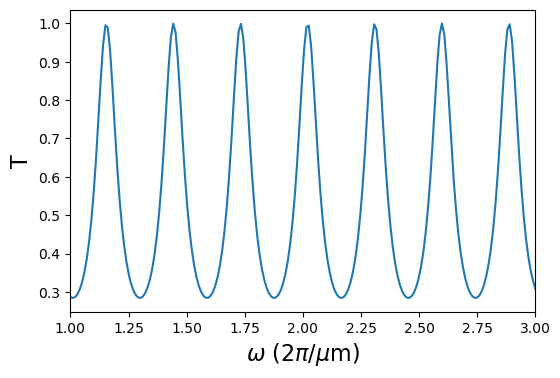

In [107]:
from matplotlib import pyplot as plt 
plt.figure(dpi=100)
plt.plot(omega/2/np.pi,T_ana)
plt.xlabel('$\omega$ (2$\pi/\mu$m)',fontsize = 16)
plt.ylabel('T',fontsize = 16)
plt.xlim([fmin,fmax])
plt.show()


## Numerical approach to get $T$

In [108]:
import meep as mp

resolution = 1000                 # pixels/um
dpml = 1.0                      # PML thickness
sz = 6 + 2*dpml
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(dpml)]

fcen = (fmin+fmax)/2          # center frequency
df = (fmax-fmin)                  # frequency width
dimensions = 1

In [109]:
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df), component=mp.Ex, 
                     center=mp.Vector3(z=-2))]


In [126]:
sim_vac = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        dimensions=dimensions,
                        resolution=resolution)

refl_fr = mp.FluxRegion(center=mp.Vector3(z=-2))
refl = sim_vac.add_flux(fcen, df, Nf, refl_fr)
tran_fr = mp.FluxRegion(center=mp.Vector3(z= 2 ))
tran = sim_vac.add_flux(fcen, df, Nf, tran_fr)
   
sim_vac.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex,
                                                        mp.Vector3(z=0), 1e-3))

empty_flux = mp.get_fluxes(tran)
empty_data = sim_vac.get_flux_data(refl)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000400066 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 8 with resolution 1000
time for set_epsilon = 0.00198102 s
-----------
on time step 58525 (time=29.2625), 6.83473e-05 s/step
field decay(t = 50.0005): 0.25000730730087717 / 0.25000730730087717 = 1.0
on time step 114274 (time=57.137), 7.17504e-05 s/step
on time step 168055 (time=84.0275), 7.43758e-05 s/step
field decay(t = 100.0005): 8.875469386219327e-17 / 0.25000730730087717 = 3.550083988360362e-16
run 0 finished at t = 100.0005 (200001 timesteps)


In [128]:
#sim.reset_meep()

# add a block with n=3.5 for the air-dielectric interface
geometry = [mp.Block(mp.Vector3(mp.inf,mp.inf,d), center=mp.Vector3(z=0),
                     material= mp.Medium(epsilon=epsi))]

sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        boundary_layers=pml_layers,
                        sources=sources,
                        dimensions=dimensions,
                        resolution=resolution)
tran = sim.add_flux(fcen, df, Nf, tran_fr)
refl = sim.add_flux(fcen, df, Nf, refl_fr)
sim.load_minus_flux_data(refl, empty_data)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(z=0), 1e-3))

refl_flux = mp.get_fluxes(refl)
tran_flux = mp.get_fluxes(tran)
freqs = mp.get_flux_freqs(refl)

wvls = np.empty(Nf)
R = np.empty(Nf)
T = np.empty(Nf)
for i in range(Nf):
        wvls[i] = 1/freqs[i]
        R[i] = -refl_flux[i]/empty_flux[i]
        T[i] = tran_flux[i]/empty_flux[i]

-----------
Initializing structure...
time for choose_chunkdivision = 0.00115299 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 8 with resolution 1000
     block, center = (0,0,0)
          size (1e+20,1e+20,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0020988 s
-----------
on time step 56050 (time=28.025), 7.13653e-05 s/step
field decay(t = 50.0005): 0.05004973264502444 / 0.05004973264502444 = 1.0
on time step 112417 (time=56.2085), 7.09636e-05 s/step
on time step 170774 (time=85.387), 6.8544e-05 s/step
field decay(t = 100.0005): 1.9333658196335253e-15 / 0.05004973264502444 = 3.8628894051159844e-14
run 0 finished at t = 100.0005 (200001 timesteps)


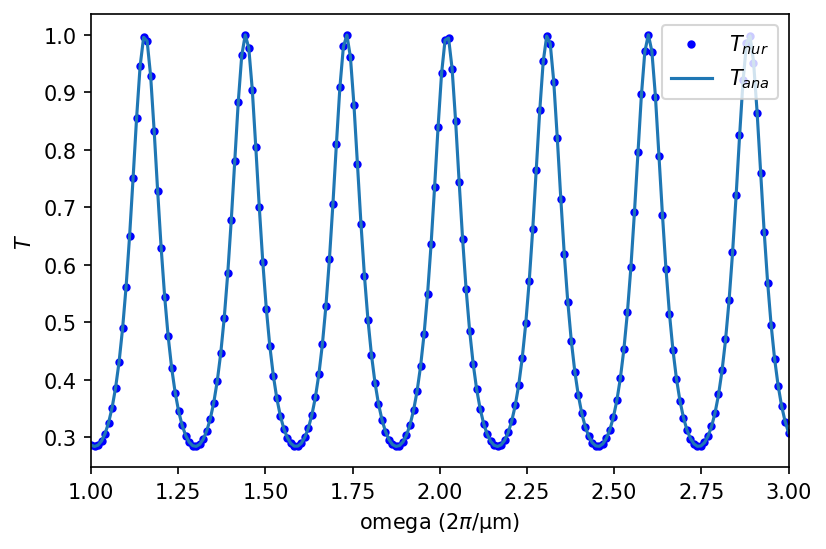

In [129]:
## compare numerical and analytical
plt.figure(dpi=150)
plt.plot(omega/2/np.pi,T,'b.',label='$T_{nur}$')
plt.plot(omega/2/np.pi,T_ana,label='$T_{ana}$')
plt.xlabel("omega ($2\pi$/μm)")
plt.ylabel("$T$")
plt.legend(loc="upper right")
plt.xlim([fmin,fmax])
plt.show()